In [1]:
import csv
import math
from tensorflow import keras
from tensorflow.keras import layers, models, applications, Sequential

import cv2
import numpy as np
#from keras import Model
#from keras.applications.mobilenetv2 import MobileNetV2, preprocess_input
#from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten
import tensorflow as tf
from keras.datasets import cifar10
import sys
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

#tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


True

### Import Dataset

In [3]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print ('Training data seize:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

Training data seize: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


### Visualize dataset

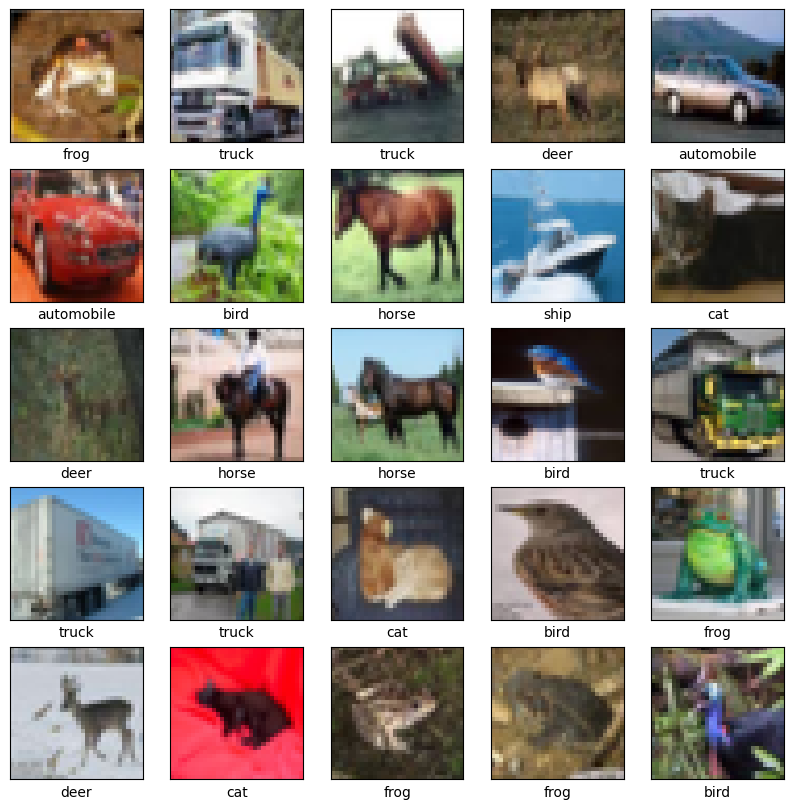

In [4]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

### Resize images for use with MobileNetV2

In [5]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNet
resized_train = []
resized_test = []
for img in train_images:
    resized_train.append(cv2.resize(img, dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC))
for img in test_images:
    resized_test.append(cv2.resize(img, dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC))

In [6]:
train_images = np.asarray(resized_train,dtype='float32')
test_images = np.asarray(resized_test,dtype='float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training data seize: (50000, 96, 96, 3) Test data size (10000, 96, 96, 3)


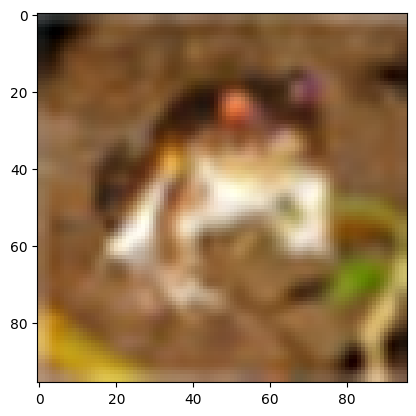

In [7]:
plt.imshow(train_images[0], cmap=plt.cm.binary)
print ('Training data seize:', train_images.shape, 'Test data size', test_images.shape)

### Download MobileNetV2 model



In [8]:
base_model = applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(96, 96, 3))

In [9]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 12, 12, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 12, 12, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 12, 12, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 12, 12, 32)  128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 6, 6, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 6, 6, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 6, 6, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 6, 6, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 6, 6, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 6, 6, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 6, 6, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 6, 6, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 3, 3, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 3, 3, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 3, 3, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 3, 3, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

### Add custom layers at the end of downloaded model

In [10]:
model = Sequential([base_model,
                    layers.Dense(1000, activation='relu'),
                    layers.Flatten(),
                    layers.Dropout(0.5),
                    layers.Dense(50, activation='relu'),
                    layers.Dense(10, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 dense (Dense)               (None, 3, 3, 1000)        1281000   
                                                                 
 flatten (Flatten)           (None, 9000)              0         
                                                                 
 dropout (Dropout)           (None, 9000)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                450050    
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                        

### Add loss function, train the model, and check accuracy on test data

In [11]:
# Compile the model with appropriate Loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_images, train_labels, epochs=10, batch_size = 8)

Epoch 1/10
6250/6250 [==============================] - 84s 12ms/step - loss: 0.8954 - accuracy: 0.6995
Epoch 2/10
6250/6250 [==============================] - 76s 12ms/step - loss: 0.6793 - accuracy: 0.7718
Epoch 3/10
6250/6250 [==============================] - 76s 12ms/step - loss: 0.6073 - accuracy: 0.7960
Epoch 4/10
6250/6250 [==============================] - 76s 12ms/step - loss: 0.5617 - accuracy: 0.8117
Epoch 5/10
6250/6250 [==============================] - 74s 12ms/step - loss: 0.5197 - accuracy: 0.8266
Epoch 6/10
6250/6250 [==============================] - 75s 12ms/step - loss: 0.4873 - accuracy: 0.8367
Epoch 7/10
6250/6250 [==============================] - 75s 12ms/step - loss: 0.4557 - accuracy: 0.8473
Epoch 8/10
6250/6250 [==============================] - 75s 12ms/step - loss: 0.4377 - accuracy: 0.8551
Epoch 9/10
6250/6250 [==============================] - 74s 12ms/step - loss: 0.4106 - accuracy: 0.8632
Epoch 10/10
6250/6250 [==============================] - 73s 12m

In [13]:
# Used to clear the memory allocation
import gc
gc.collect()

1941

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Print the loss and accuracy of the test data


score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Print the confusion matrix
test_predict_prob=model.predict(test_images) 
test_predict=np.argmax(test_predict_prob,axis=1)

report = """
Confusion Matrix:
{}
""".format(confusion_matrix(test_labels, test_predict))
print(report)

# Print the classification report
print("Classification report")
target_names = ["Class {}: {}".format(i, class_names[i]) for i in range(10)]
print(classification_report(test_labels, test_predict, target_names=target_names))

Test loss: 0.6334988474845886
Test accuracy: 0.8198999762535095

Confusion Matrix:
[[842  11  32   9  20   4   1   7  39  35]
 [ 11 907   0   7   2   3   3   0  20  47]
 [ 24   2 775  47  83  26  33   7   2   1]
 [  2   5  45 719  56 103  45  10   8   7]
 [  5   1  39  31 849  18  19  34   2   2]
 [  3   3  23 175  43 706  23  21   1   2]
 [  5   2  37  52  69  17 810   4   3   1]
 [ 10   2  19  50  67  42   3 799   1   7]
 [ 46  19  11   7   2   0   2   3 893  17]
 [  9  55   0  15   3   0   3   2  14 899]]

Classification report
                     precision    recall  f1-score   support

  Class 0: airplane       0.88      0.84      0.86      1000
Class 1: automobile       0.90      0.91      0.90      1000
      Class 2: bird       0.79      0.78      0.78      1000
       Class 3: cat       0.65      0.72      0.68      1000
      Class 4: deer       0.71      0.85      0.77      1000
       Class 5: dog       0.77      0.71      0.74      1000
      Class 6: frog       0.86     

### Extra code for producing different plots, accuracy values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

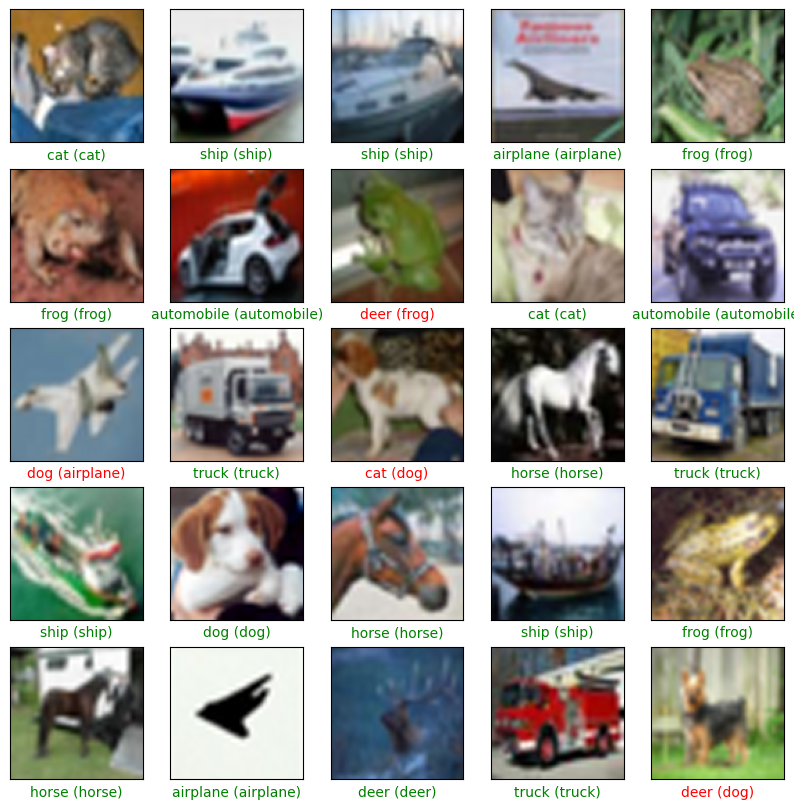

In [15]:
# Code to visualize predictions
# Incorrect predictions are highlighted in red
%matplotlib inline
import numpy as np
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

    predicted_label = test_predict[i]
    true_label = test_labels[i]
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label], 
                                  class_names[true_label[0]]),
                                  color=color)

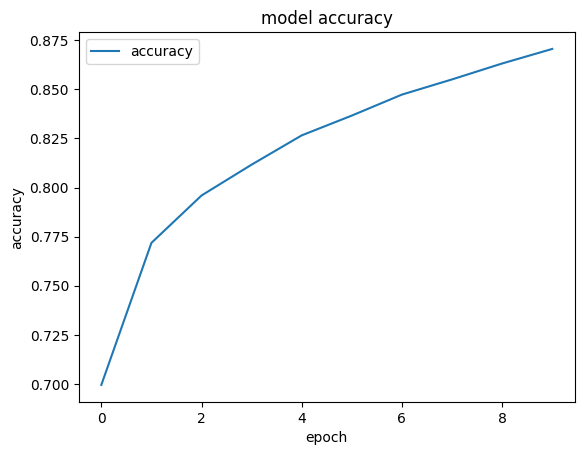

In [16]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

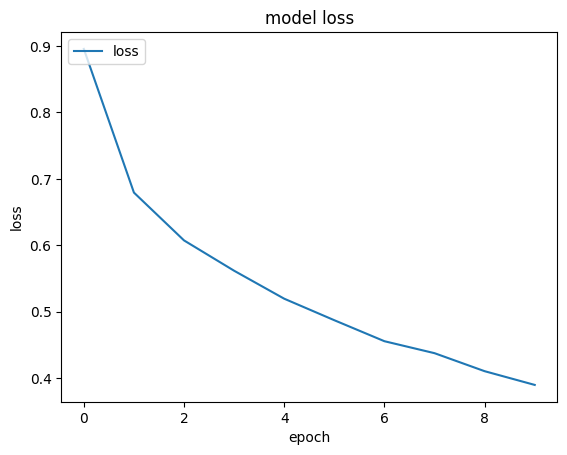

In [17]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()